# Competitor analysis: topic modelling of Bauldur's Gate 3 reviews on Steam

## Latent Dirichlet Allocation

In [1]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from config import BG3_data_file_path
from functions import (load_data, 
                       process_df, 
                       plot_distributions, 
                       plot_correlation_matrix, 
                       process_reviews,
                       make_wordcloud,
                       create_vectorizers,
                       create_dictionary,
                       train_lda_model,
                       inspect_reviews)
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data file
df = load_data(BG3_data_file_path)
#Show data frame's first 5 entries
df.head(5)

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location
0,146197289,"{'steamid': '76561198209057388', 'num_games_ow...",english,my work is really cutting into my Baldur's Gat...,1694565640,1694565640,True,7830,2987,0.980962,0,True,False,False,True,NaN
1,153859247,"{'steamid': '76561198412806684', 'num_games_ow...",english,You can convince bosses to kill themselves. 10/10,1702909919,1702909919,True,3605,900,0.980739,10,True,False,False,True,NaN
2,143924257,"{'steamid': '76561198022720435', 'num_games_ow...",english,Possessed a guard and had them open a gate con...,1691783669,1691783669,True,3124,1268,0.978952,12,True,False,False,True,NaN
3,146776206,"{'steamid': '76561198007607100', 'num_games_ow...",english,I have only one point of criticism:\nThis game...,1695386806,1701885967,True,1320,6,0.978480,28,True,False,False,True,NaN
4,143578821,"{'steamid': '76561198004904749', 'num_games_ow...",english,No microtransactions\nNo in-game purchases\nNo...,1691401740,1691401740,True,15452,51,0.978366,0,True,False,False,True,NaN


In [3]:
# The function process_df processes a dataframe by converting the 'author' column to dictionaries; extracting 'steamid', 
# 'num_games_owned', 'num_reviews', and 'playtime_at_review' from 'author'; converting 'playtime_at_review' to hours;
# formatting 'timestamp_created' to 'YYYY-MM-DD'; selecting specific columns and removing duplicate reviews;
# adding a 'review_length' column for word count.
# The function returns the refined dataframe.
new_df = process_df(df)
new_df.head()

,review,playtime_at_review,num_games_owned,voted_up,timestamp_created_date,review_length
0,my work is really cutting into my Baldur's Gat...,41.933333,0,True,2023-09-13,14
1,You can convince bosses to kill themselves. 10/10,200.900000,95,True,2023-12-18,8
2,Possessed a guard and had them open a gate con...,83.833333,0,True,2023-08-11,40
3,I have only one point of criticism:\nThis game...,373.150000,353,True,2023-09-22,107
4,No microtransactions\nNo in-game purchases\nNo...,27.900000,418,True,2023-08-07,33


### EDA

In [4]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 495 entries, 0 to 499
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   review                  495 non-null    object 
 1   playtime_at_review      495 non-null    float64
 2   num_games_owned         495 non-null    int64  
 3   voted_up                495 non-null    bool   
 4   timestamp_created_date  495 non-null    object 
 5   review_length           495 non-null    int64  
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 23.7+ KB


In [5]:
# Summary statistics of the numerical columns of the dataframe
new_df.describe()

,playtime_at_review,num_games_owned,review_length
count,495.000000,495.000000,495.000000
mean,115.905051,450.880808,138.785859
std,153.370717,1069.287632,254.556586
min,0.333333,0.000000,1.000000
25%,25.608333,0.000000,12.000000
50%,69.183333,109.000000,37.000000
75%,152.450000,452.000000,126.500000
max,1440.983333,11861.000000,1443.000000


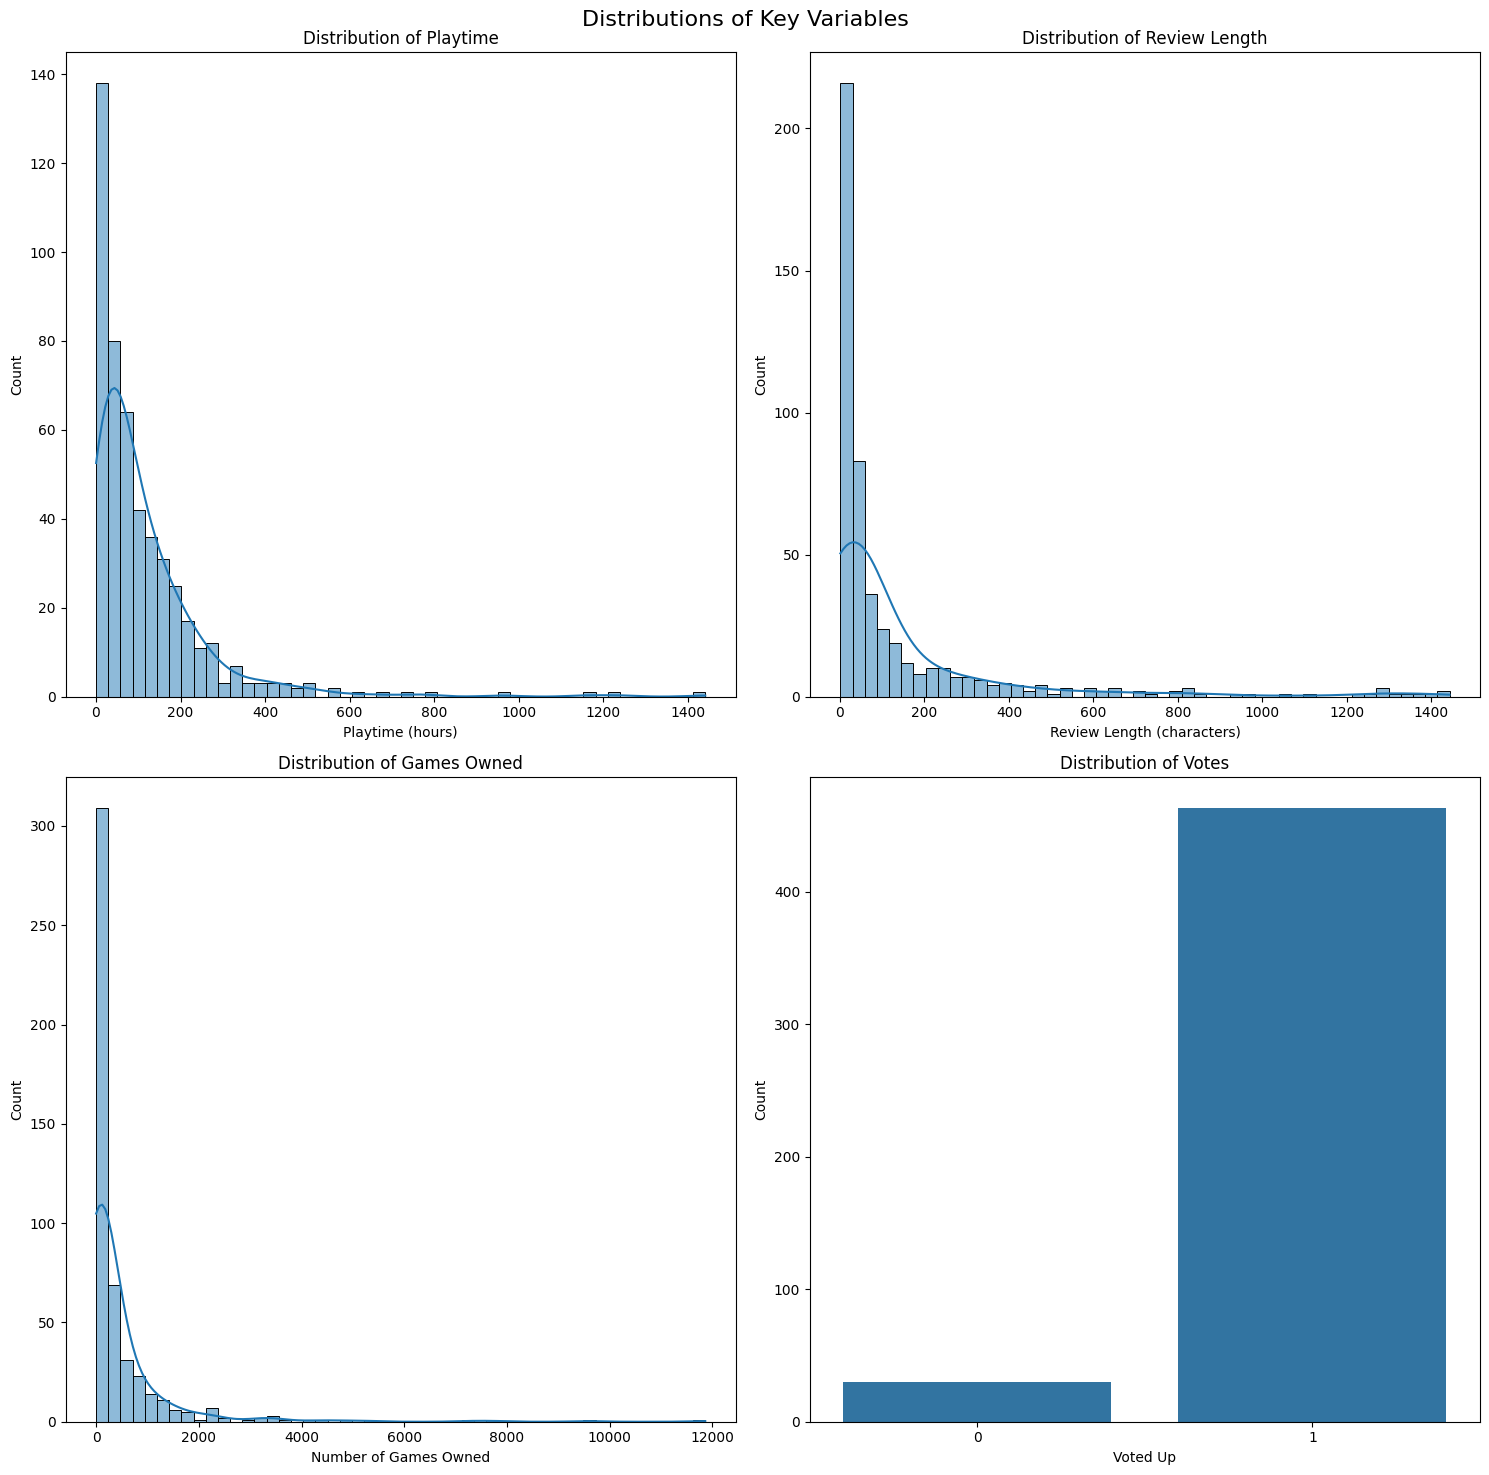

In [33]:
# The function plot_distributions creates a 2x2 grid of subplots to visualize distributions of key variables in the dataframe. 
# It plots the distribution of variables 'playtime_at_review', 'review_length', 'num_games_owned', with a histogram and KDE; 
# and the count of 'voted_up' values with a count plot. 
# We can see that all continuous variables are heavily right skewed, with lower values predominating. 
# We can also see that the large majority of reviews are positive.

plot_distributions(new_df)

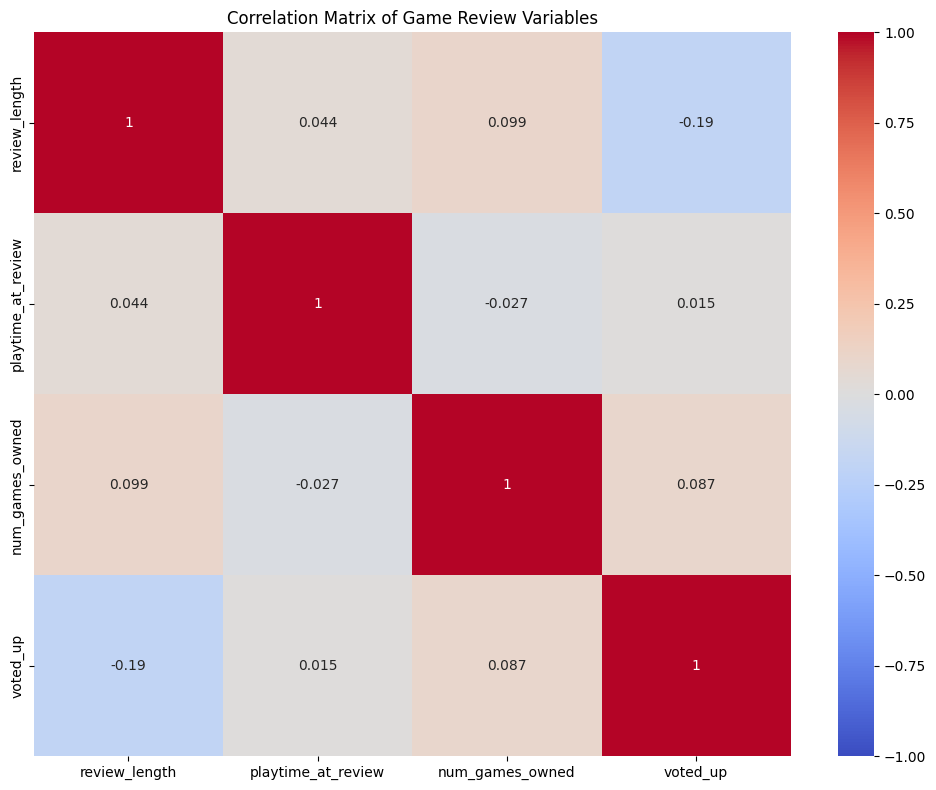

In [32]:
# The plot_correlation_matrix function creates a visual representation of the correlations between the numeric variables in the dataframe. 
# It converts the categorical variable "voted_up" to numerical, calculates correlations between the selected features 
# (review length, playtime at review, number of games owned, and whether the review was voted up), and generates a color-coded heatmap 
# using seaborn. This visualization helps identify relationships and patterns among the variables, aiding in the analysis of factors 
# that might influence game reviews.
# We can see that there are no strong correlations among the variables, implying they are all independent.

plot_correlation_matrix(new_df)

### Text preprocessing 

In [8]:
# The process_reviews function performs comprehensive text preprocessing on the 'review' column of the dataframe. 
# It ensures necessary NLTK datasets are downloaded, then applies a series of text cleaning operations including lowercasing, URL removal, 
# punctuation handling, and non-alphabetic character removal. The function tokenizes the text, removes stopwords, applies lemmatization, 
# and eliminates single-letter words. This preprocessing pipeline standardizes the review text, reducing noise and preparing it for further 
# natural language processing tasks, creating a new 'processed_review' column in the dataframe.
new_df = process_reviews(new_df)
# Visualize the dataframe with new column
new_df.head()

,review,playtime_at_review,num_games_owned,voted_up,timestamp_created_date,review_length,processed_review
0,my work is really cutting into my Baldur's Gat...,41.933333,0,1,2023-09-13,14,work really cutting baldur gate time quit
1,You can convince bosses to kill themselves. 10/10,200.900000,95,1,2023-12-18,8,convince boss kill
2,Possessed a guard and had them open a gate con...,83.833333,0,1,2023-08-11,40,possessed guard open gate containing giant spi...
3,I have only one point of criticism:\nThis game...,373.150000,353,1,2023-09-22,107,one point criticism game lack proper ending ep...
4,No microtransactions\nNo in-game purchases\nNo...,27.900000,418,1,2023-08-07,33,microtransactions game purchase paywalls game ...


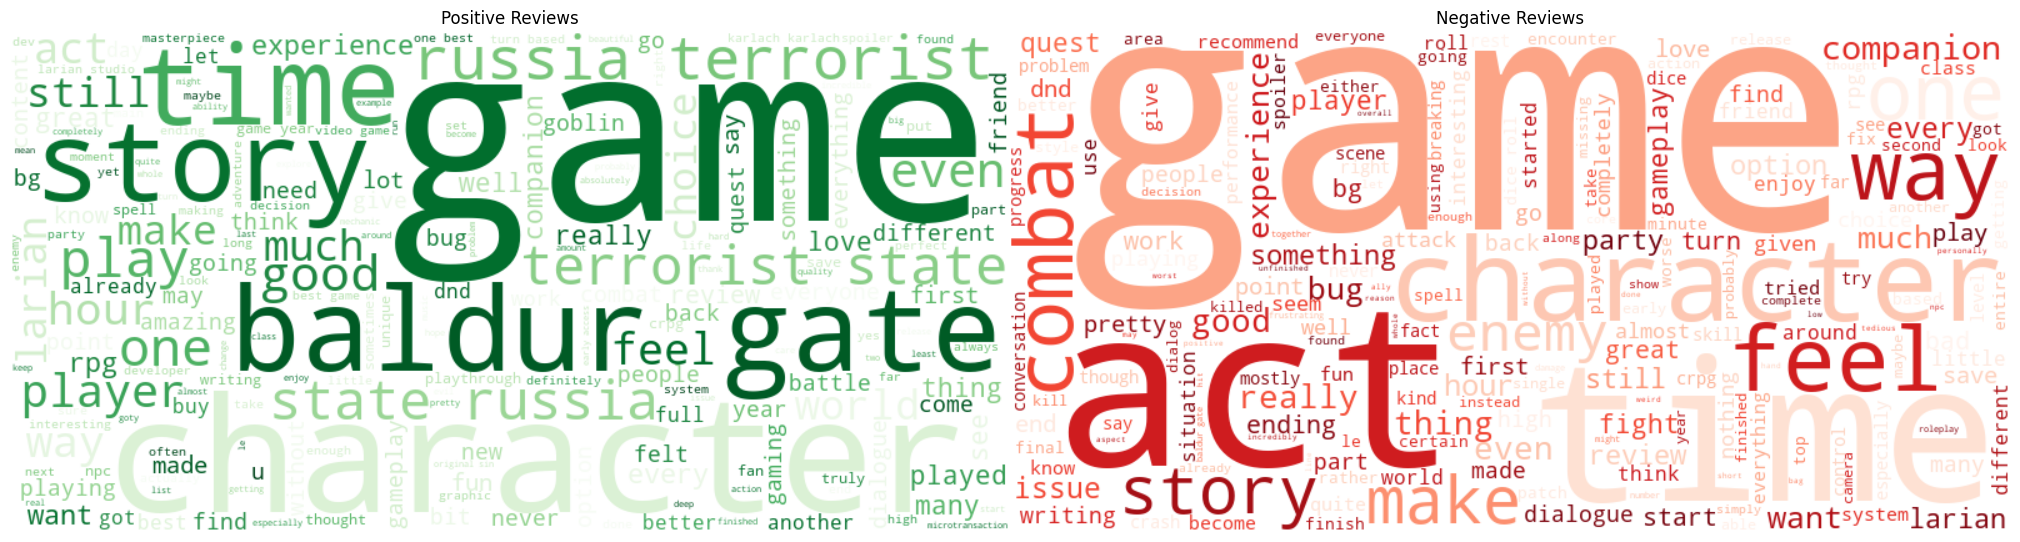

In [9]:
# The make_wordcloud function generates and displays comparative word clouds for positive and negative game reviews. 
# It separates the processed review text based on the 'voted_up' column, creates two word clouds using different color schemes 
# (green for positive, red for negative), and visualizes them side-by-side in a single figure. This visual representation allows for
# quick identification of frequently occurring words in both positive and negative reviews, providing insights into the language patterns 
# and themes associated with different game review sentiments.
# We can see a big overlap in aspects between positive and negative reviews, implying that, interestingly enough, the same aspects that
# make some players love the game also make other dislike it. A clear word present only in the negative reviews is 'bug', which is a 
# very common complain in video game reviews.
# We also see some unexpected words in the positive reviews, such as 'terrorist' and 'Russia'.
make_wordcloud(new_df)

### Document-term matrix

In [10]:
# The create_vectorizers function generates two types of text vectorization models for processed game reviews: a Count Vectorizer and 
# a TF-IDF Vectorizer. It applies the Count Vectorizer with specified document frequency thresholds to create a term frequency matrix 
# and extract feature names excluding from the vocabulary words that appear in less than 10% and more than 95% of the reviews.
# These parameters help balance the vocabulary, focusing on words that are neither too rare nor too common.
# It then applies the TF-IDF Vectorizer to create a TF-IDF matrix. This function prepares the review text 
# for various natural language processing tasks by transforming the textual data into numerical representations, capturing both raw 
# word frequencies and the importance of words across the document collection.

count_vectorizer, tfidf_vectorizer, tf_matrix, tfidf_matrix, tf_feature_names = create_vectorizers(new_df)

# Print basic information

print("Term Frequency Matrix Shape:", tf_matrix.shape)
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
print("Number of unique terms:", len(tf_feature_names))

Term Frequency Matrix Shape: (495, 54)
TF-IDF Matrix Shape: (495, 5699)
Number of unique terms: 54


In [11]:
# The create_dictionary function prepares the review text data for topic modeling using Gensim. It tokenizes the processed reviews 
# into lists of words, creates a Gensim dictionary object that maps words to unique IDs, and generates a corpus where each review is 
# represented as a bag-of-words. This function transforms the text data into a structured format suitable for topic modeling 
# with Latent Dirichlet Allocation). The resulting dictionary and corpus serve as the foundation for discovering topics within the reviews.
texts, dictionary, corpus = create_dictionary(new_df)

### LDA hyperparameter tuning and modeling

Manually run different hyperparameters and topic numbers, exploring also the plot output to ensure topics make sense and are interpretable

In [12]:
# The train_lda_model function creates and trains a Latent Dirichlet Allocation topic model using Gensim's LdaMulticore 
# implementation. It takes preprocessed text data, a corpus, and a dictionary as inputs, along with several hyperparameters for model 
# tuning. The function utilizes parallel processing to efficiently train the model on the review data. After training, it 
# calculates the model's coherence score using the CV metric, which measures the interpretability of the discovered topics. 
# This function reveals themes in the reviews and assesses the quality of the topic model, enabling insights into the content 
# of the review texts.
# After manually running different hyperparameter combinations and inspecting the plot, settled on the below.
num_topics = 12
alpha = 0.05
eta = 0.05
passes = 200
chunksize = 500

model, coherence = train_lda_model(corpus, dictionary, texts, num_topics, alpha, eta, passes, chunksize)
print(f"Coherence Score: {coherence}")

# Visualize with pyLDAvis
vis_data = gensimvis.prepare(model, corpus, dictionary)
pyLDAvis.display(vis_data)

Coherence Score: 0.33967275991141815


There are some topics with strange terms. I want to manually inspect the reviews that contain those words, find their row number, and depending on their content, potentially delete them as outliers.

In [23]:
# The inspect_reviews function is a targeted search tool for analyzing the reviews. It filters the specified column for reviews containing 
# any of the given search strings, ignoring case. 
# The function returns both the indices of matching rows and the full text of the matching reviews. This allows for efficient 
# exploration of specific themes or keywords within the review dataset without manually sifting through the entire corpus.
# Below we search for 'yoda', 'lego'
search_strings = ['yoda', 'lego']
column = 'review'
row_indices, review_text = inspect_reviews(new_df, column=column, search_strings=search_strings)
print(f"Row numbers containing the specified strings: {row_indices} \n")
for text in review_text.tolist():
    print(text)

Row numbers containing the specified strings: [] 



In [20]:
# Sounds random, drop the filtered row from the dataframe
new_df = new_df.drop(row_indices)

In [24]:
# Search for 'Russia'
search_strings = ['russia']
column = 'review'
row_indices, review_text = inspect_reviews(new_df, column=column, search_strings=search_strings)
print(f"Row numbers containing the specified strings: {row_indices} \n")
for text in review_text.tolist():
    print(text)

Row numbers containing the specified strings: [31] 

Baldur's Gate 3 is an excellent game. I haven't enjoyed a game this much since I was a kid playing Dragon Age for the first time. Everything is so well-thought-out, down to the smallest detail. You can play alone or with friends, and you can choose to be a force for good or chaos. Just be prepared to read a lot of text and enjoy the ride.

Here are some of the things I love about Baldur's Gate 3:

The story is engaging and full of twists and turns.The characters are well-developed and relatable.The combat is challenging and rewarding.The world is vast and full of secrets to discover.

If you're a fan of role-playing games, then Baldur's Gate 3 is a must-play. It's an epic adventure that will keep you hooked for hours on end.

5/5 parasites

RUSSIA IS A TERRORIST STATE!RUSSIA IS A TERRORIST STATE!RUSSIA IS A TERRORIST STATE!RUSSIA IS A TERRORIST STATE!RUSSIA IS A TERRORIST STATE!RUSSIA IS A TERRORIST STATE!RUSSIA IS A TERRORIST STATE!

In [25]:
# Looks like a legitimate review with an anti-Russia phrase repeated many times.
# Remove whole string from review and processed review.
new_df = new_df.replace(['RUSSIA IS A TERRORIST STATE!','russia terrorist state'], '', regex=True)

In [26]:
# Search for 'pizza'
search_strings = ['pizza']
column = 'review'
row_indices, review_text = inspect_reviews(new_df, column=column, search_strings=search_strings)
print(f"Row numbers containing the specified strings: {row_indices} \n")
for text in review_text.tolist():
    print(text)

Row numbers containing the specified strings: [463] 

New York styled Pizza:
Pizza dough:
14 g instant yeast
617g water - 95F
950g all-purpose flour
19g fine sea salt
25g granulated sugar
American Pizza Sauce and Toppings:
1 tablespoon (14g) butter
1 tablespoon (9g) extra virgin olive oil
6 cloves garlic, rough chopped
2 teaspoons (4g) red pepper flakes
28 oz (794g) can of crushed tomato
2 teaspoons (2g) dried oregano
1.5 tablespoons (21g) granulated sugar
salt and pepper to taste
Splash of olive oil
2 cups (227g) low moisture mozzarella, fresh grated
2 cups (200g) Monterey jack cheese, fresh grated
1/2 cup (26g) parmigiano reggiano, fresh grated
American Pizza Dough:
Preheat the oven and a baking steel or pizza stone at 500F for 45 minutes before utilizing it.
Whisk yeast and sugar into your water, and allow it to sit for 5 minutes. In a separate bowl, add flour and salt and mix by hand to combine. Pour your water mixture into your flour and mix by hand until you get a rough dough, th

In [27]:
# Looks like a recipe for pizza...
# Drop the filtered row from the dataframe
new_df = new_df.drop(row_indices)

### New LDA with cleaned dataset

Redo steps of LDA model with cleaned dataset, recycled code

In [29]:
count_vectorizer, tfidf_vectorizer, tf_matrix, tfidf_matrix, tf_feature_names = create_vectorizers(new_df)
texts, dictionary, corpus = create_dictionary(new_df)
# Train LDA model
num_topics = 11
alpha = 0.5
eta = 0.05
passes = 200
chunksize = 500

model, coherence = train_lda_model(corpus, dictionary, texts, num_topics, alpha, eta, passes, chunksize)

# Print basic information
print("Term Frequency Matrix Shape:", tf_matrix.shape)
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
print("Number of unique terms:", len(tf_feature_names))
print(f"Coherence Score: {coherence}")

vis_data = gensimvis.prepare(model, corpus, dictionary)

# Visualize
pyLDAvis.display(vis_data)

Term Frequency Matrix Shape: (493, 54)
TF-IDF Matrix Shape: (493, 5621)
Number of unique terms: 54
Coherence Score: 0.3686546507862971


### Topic names

Here we decide what names to give each collection of terms (topic) picked out by the model

**Topic 1**: "Game mechanics and storytelling"  focuses on core game elements like characters, story, companions, quests, and player choices.

**Topic 2**: "Player engagement and time investment"  highlights player engagement, time spent playing, and overall positive sentiment towards the game.

**Topic 3**: "RPG elements and world-building"  focuses on the RPG aspects of the game, including character choices, companions, and the game world.

**Topic 4**: "Game development and player expectations"  seems to cover aspects of the game's development, player expectations, and how it compares to previous titles in the series.

**Topic 5**: "Emotional impact and experience"  emphasizes the emotional connection players have with the game and its overall quality as an experience.

**Topic 6**: "Developer recognition and genre impact"  discusses Larian Studios and the game's impact on the RPG genre, comparing it to other notable titles.

**Topic 7**: "CRPG Mechanics"  focuses on specific CRPG (Computer Role-Playing Game) elements like dice rolls, party mechanics, and combat.

**Topic 8**: "Game impact on players“  emphasizes the game's impact on players, discussing it as one of the best gaming experiences.

**Topic 9**: "General game quality assessment"  seems to cover various aspects of the game's quality, including story, gameplay, graphics, and value for money.

**Topic 10**: "Controversial content"  seems to cover various player reactions, including some controversial or unexpected elements (e.g., sex, pets, gay content).

**Topic 11**: "Character appreciation"  highlights specific characters (Karlach, Shadowheart, Astarion) and suggests strong positive sentiment (GOTY - Game of the Year).